In [1]:
!nvidia-smi

Mon Feb 24 21:15:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.86       Driver Version: 430.86       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX230      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8    N/A /  N/A |     63MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Library

In [1]:
import numpy as np
import pandas as pd
import gc, os, time, sys, random
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
#import lightgbm as lgb
#import xgboost as xgb
#import catboost as cb


import numpy
import six
import torch
from torch.utils.data.dataset import Dataset
import cv2
from skimage.transform import AffineTransform, warp
import albumentations as A
from typing import List
from torch import nn
from torch.nn.parameter import Parameter
import pretrainedmodels
import torch.nn.functional as F
from torch.nn import Sequential
import math
from torch.nn import init
import argparse
from distutils.util import strtobool
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader
import warnings
from ignite.metrics.metric import Metric
from logging import getLogger
from time import perf_counter
import json
from logging import getLogger
# from chainer_chemistry.utils import save_json
from ignite.engine.engine import Engine, Events
from ignite.metrics import Average

# --- setup ---
pd.set_option('max_columns', 50)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Initial Settings

In [34]:
debug=False
submission=False
batch_size=128
device='cuda:0'
out='.'
image_size=64
arch='pretrained'
model_name='se_resnext50_32x4d'
datadir = '../../input'
pdatadir = '../../input/parquet'
featherdir = '../../input/feather'
outdir = '../../output'
logdir = '../logs'
modeldir = '../models'

In [3]:
os.listdir(datadir)

['.gitkeep',
 '.ipynb_checkpoints',
 'class_map.csv',
 'feather',
 'parquet',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

# Dataset

In [4]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(f'{pdatadir}/{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(f'{featherdir}/{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [5]:
class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError

In [6]:
class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

# Import Table Data

In [7]:
%%time
train = pd.read_csv(f'{datadir}/train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
Wall time: 51.6 s


In [8]:
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [10]:
train_dataset = BengaliAIDataset(train_images, train_labels)

In [11]:
image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


# Preprocessing

In [12]:
def affine_image(img):
    """
    Args:
        img: (h, w) or (1, h, w)
    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

# Data Check

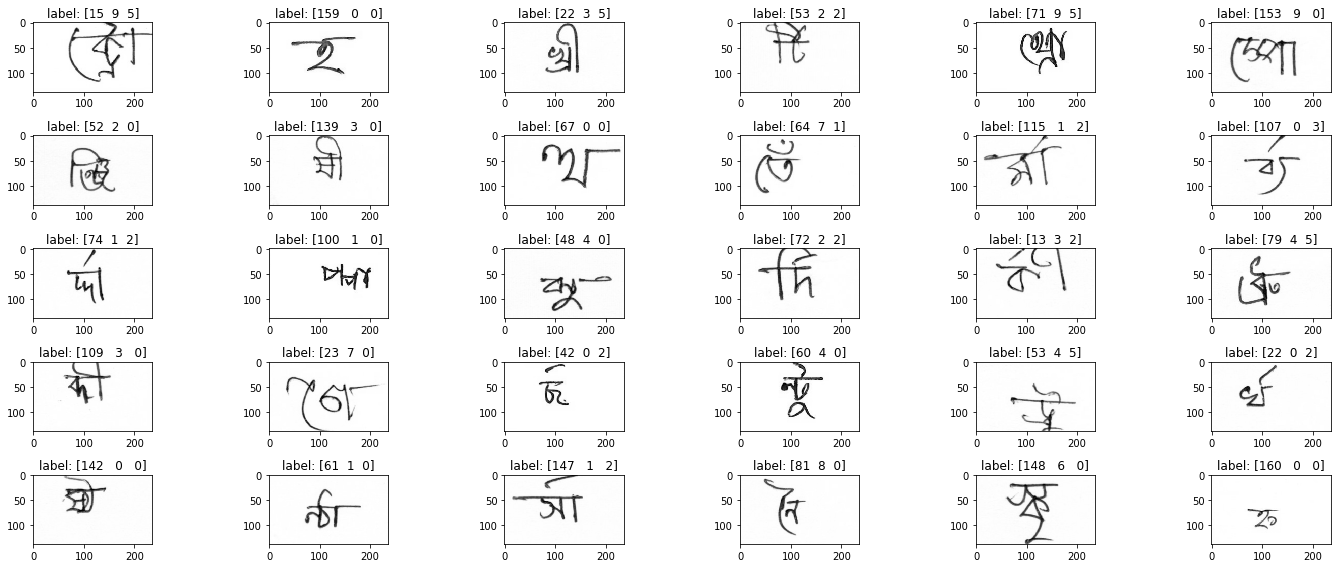

<Figure size 432x288 with 0 Axes>

In [13]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

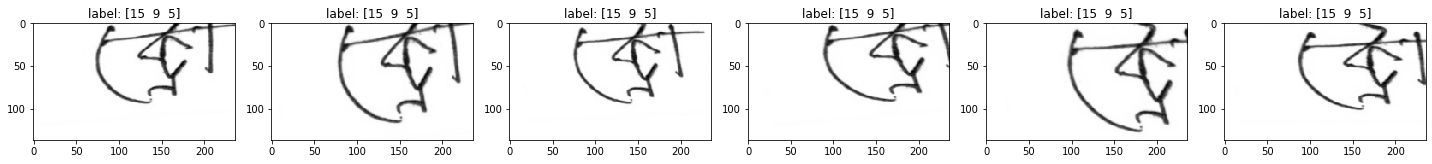

In [14]:
nrow, ncol = 1, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

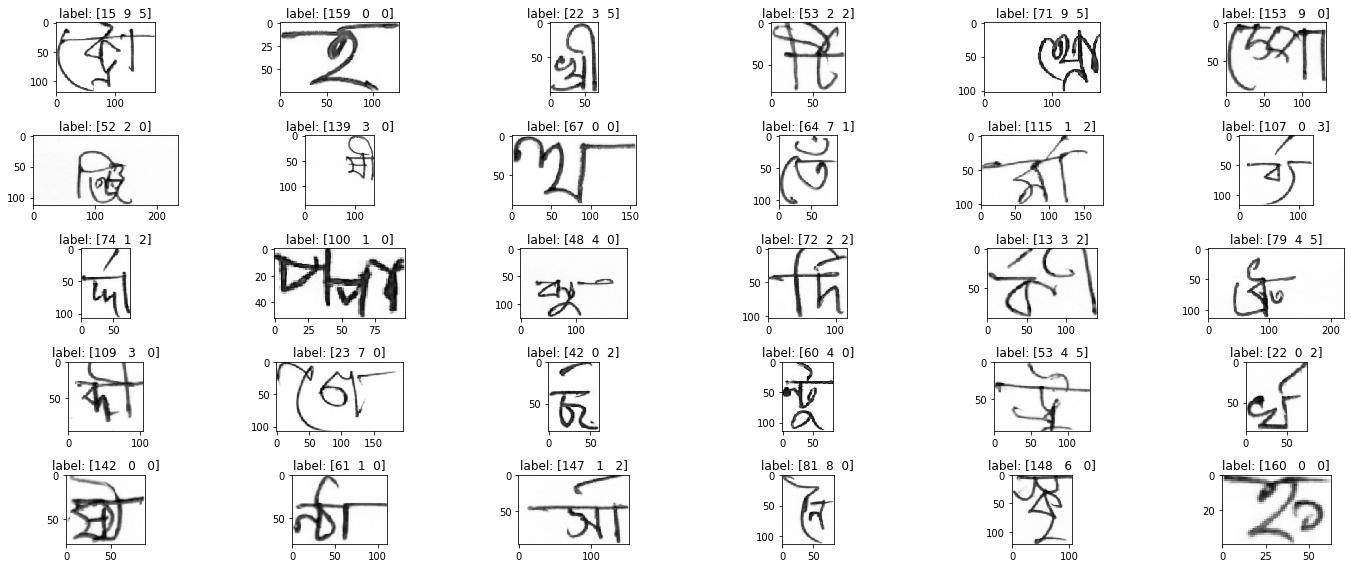

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

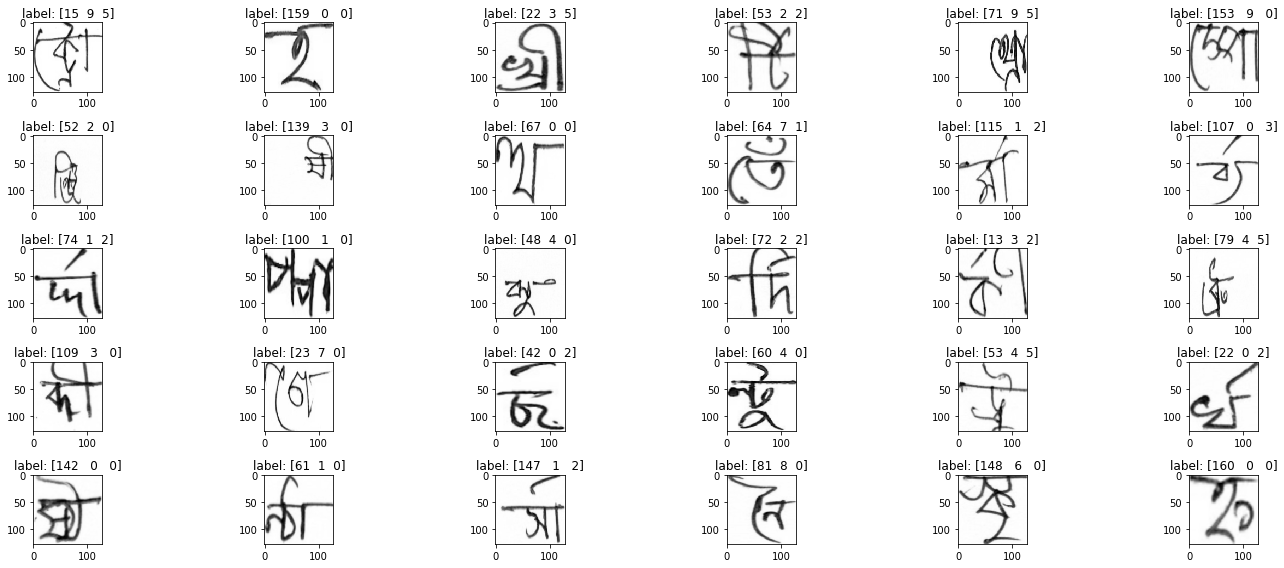

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

# Transform

In [17]:
def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [18]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

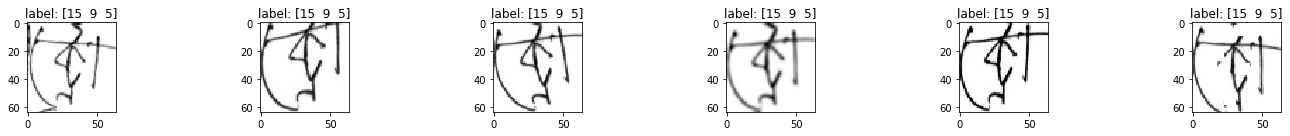

In [28]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

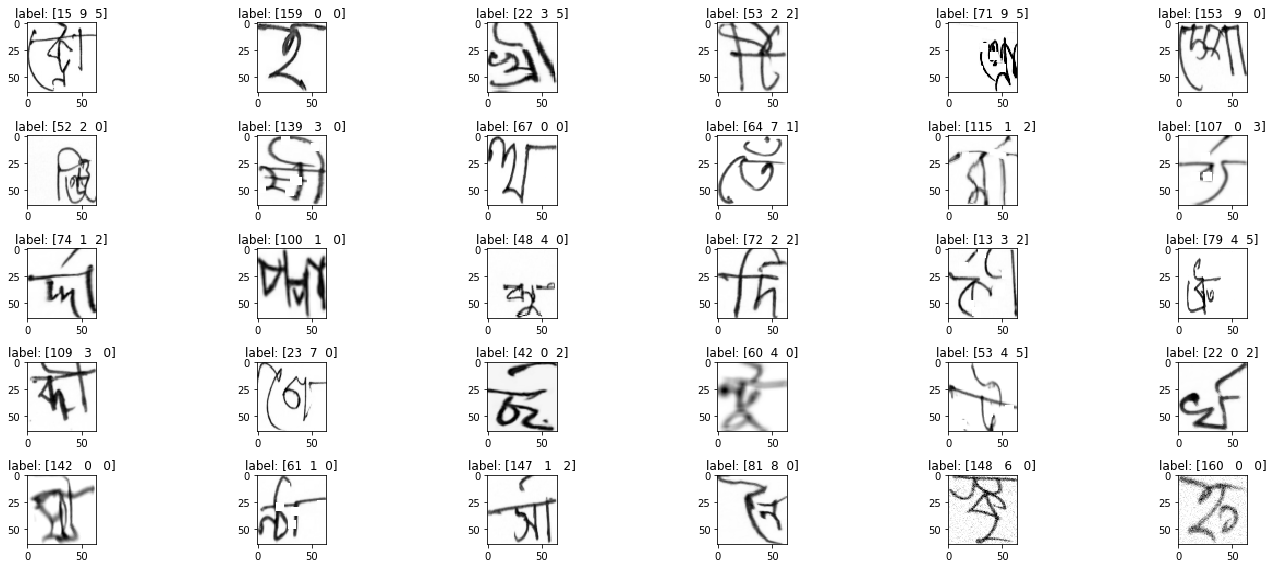

In [29]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [19]:
def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out

In [20]:
class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))

In [21]:
class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [22]:
class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [23]:
class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [24]:
def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [25]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084


In [26]:
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
#predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)

n_total 186
predictor <class '__main__.PretrainedCNN'>


In [27]:
def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

In [28]:
class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]

def create_trainer(classifier, optimizer, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()
        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        loss, metrics, pred_y = classifier(x, y)
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    trainer = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            _, metrics, pred_y = classifier(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')

In [29]:
class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float32)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)

In [30]:
def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [32]:
# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor, filepath=f'{modeldir}/predictor_02.pt'))

# Training Model

In [35]:
sts = time.time()
trainer.run(train_loader, max_epochs=30)
ed = time.time()
print('Model trained in {:.2f} min'.format((ed-sts)/60))

epoch      2 train/loss  2.878557 train/loss_grapheme  1.876687 train/loss_vowel  0.499268 train/loss_consonant  0.502602 train/acc_grapheme  0.567152 train/acc_vowel  0.867290 train/acc_consonant  0.877576 train/recall  0.696709 valid/loss  1.051322 valid/loss_grapheme  0.690127 valid/loss_vowel  0.187291 valid/loss_consonant  0.173904 valid/acc_grapheme  0.820557 valid/acc_vowel  0.947977 valid/acc_consonant  0.954384 valid/recall  0.878280 lr  0.001000 elapsed_time  3565.224359 


epoch      3 train/loss  1.044116 train/loss_grapheme  0.668488 train/loss_vowel  0.199645 train/loss_consonant  0.175982 train/acc_grapheme  0.832562 train/acc_vowel  0.946840 train/acc_consonant  0.950934 train/recall  0.879641 valid/loss  0.710135 valid/loss_grapheme  0.474934 valid/loss_vowel  0.116780 valid/loss_consonant  0.118420 valid/acc_grapheme  0.875739 valid/acc_vowel  0.969347 valid/acc_consonant  0.965692 valid/recall  0.914682 lr  0.001000 elapsed_time  7185.145450 


epoch      4 train/loss  0.761818 train/loss_grapheme  0.482423 train/loss_vowel  0.148396 train/loss_consonant  0.130999 train/acc_grapheme  0.876951 train/acc_vowel  0.960153 train/acc_consonant  0.961962 train/recall  0.910713 valid/loss  0.572791 valid/loss_grapheme  0.375959 valid/loss_vowel  0.106842 valid/loss_consonant  0.089991 valid/acc_grapheme  0.902388 valid/acc_vowel  0.970955 valid/acc_consonant  0.973730 valid/recall  0.928417 lr  0.001000 elapsed_time  10723.147896 


epoch      5 train/loss  0.615685 train/loss_grapheme  0.384939 train/loss_vowel  0.122906 train/loss_consonant  0.107841 train/acc_grapheme  0.900019 train/acc_vowel  0.966886 train/acc_consonant  0.968500 train/recall  0.927029 valid/loss  0.472005 valid/loss_grapheme  0.310587 valid/loss_vowel  0.082954 valid/loss_consonant  0.078464 valid/acc_grapheme  0.918920 valid/acc_vowel  0.978342 valid/acc_consonant  0.976030 valid/recall  0.938951 lr  0.001000 elapsed_time  14435.813409 


epoch      6 train/loss  0.524082 train/loss_grapheme  0.324843 train/loss_vowel  0.105880 train/loss_consonant  0.093359 train/acc_grapheme  0.914923 train/acc_vowel  0.970835 train/acc_consonant  0.972720 train/recall  0.936849 valid/loss  0.467045 valid/loss_grapheme  0.306696 valid/loss_vowel  0.082342 valid/loss_consonant  0.078008 valid/acc_grapheme  0.919816 valid/acc_vowel  0.977696 valid/acc_consonant  0.977049 valid/recall  0.940514 lr  0.001000 elapsed_time  17864.625023 


epoch      7 train/loss  0.456806 train/loss_grapheme  0.282164 train/loss_vowel  0.092067 train/loss_consonant  0.082575 train/acc_grapheme  0.924874 train/acc_vowel  0.974556 train/acc_consonant  0.975686 train/recall  0.944457 valid/loss  0.453203 valid/loss_grapheme  0.292353 valid/loss_vowel  0.090119 valid/loss_consonant  0.070731 valid/acc_grapheme  0.924956 valid/acc_vowel  0.975456 valid/acc_consonant  0.978603 valid/recall  0.942827 lr  0.001000 elapsed_time  21282.119835 


epoch      8 train/loss  0.406838 train/loss_grapheme  0.247663 train/loss_vowel  0.082817 train/loss_consonant  0.076357 train/acc_grapheme  0.933493 train/acc_vowel  0.977090 train/acc_consonant  0.977448 train/recall  0.950566 valid/loss  0.393020 valid/loss_grapheme  0.256383 valid/loss_vowel  0.069991 valid/loss_consonant  0.066645 valid/acc_grapheme  0.933002 valid/acc_vowel  0.981091 valid/acc_consonant  0.980333 valid/recall  0.949867 lr  0.001000 elapsed_time  24683.453543 


epoch      9 train/loss  0.368565 train/loss_grapheme  0.222801 train/loss_vowel  0.077081 train/loss_consonant  0.068683 train/acc_grapheme  0.939302 train/acc_vowel  0.978638 train/acc_consonant  0.979573 train/recall  0.955029 valid/loss  0.404690 valid/loss_grapheme  0.270270 valid/loss_vowel  0.069673 valid/loss_consonant  0.064747 valid/acc_grapheme  0.932359 valid/acc_vowel  0.981190 valid/acc_consonant  0.981665 valid/recall  0.948844 lr  0.001000 elapsed_time  28082.200659 


epoch     10 train/loss  0.335101 train/loss_grapheme  0.201945 train/loss_vowel  0.068781 train/loss_consonant  0.064376 train/acc_grapheme  0.944102 train/acc_vowel  0.980690 train/acc_consonant  0.981399 train/recall  0.958950 valid/loss  0.370565 valid/loss_grapheme  0.241674 valid/loss_vowel  0.068511 valid/loss_consonant  0.060381 valid/acc_grapheme  0.938139 valid/acc_vowel  0.982771 valid/acc_consonant  0.981428 valid/recall  0.954978 lr  0.001000 elapsed_time  31480.375625 


epoch     11 train/loss  0.308911 train/loss_grapheme  0.183815 train/loss_vowel  0.066349 train/loss_consonant  0.058747 train/acc_grapheme  0.949158 train/acc_vowel  0.981150 train/acc_consonant  0.982549 train/recall  0.962638 valid/loss  0.385062 valid/loss_grapheme  0.256518 valid/loss_vowel  0.067327 valid/loss_consonant  0.061216 valid/acc_grapheme  0.934683 valid/acc_vowel  0.981975 valid/acc_consonant  0.981963 valid/recall  0.946990 lr  0.001000 elapsed_time  34876.361247 


epoch     12 train/loss  0.287736 train/loss_grapheme  0.170845 train/loss_vowel  0.061269 train/loss_consonant  0.055623 train/acc_grapheme  0.952145 train/acc_vowel  0.982705 train/acc_consonant  0.982997 train/recall  0.963262 valid/loss  0.374509 valid/loss_grapheme  0.244384 valid/loss_vowel  0.068579 valid/loss_consonant  0.061545 valid/acc_grapheme  0.937791 valid/acc_vowel  0.981937 valid/acc_consonant  0.981278 valid/recall  0.953277 lr  0.001000 elapsed_time  38290.283806 


epoch     13 train/loss  0.267863 train/loss_grapheme  0.158959 train/loss_vowel  0.057594 train/loss_consonant  0.051309 train/acc_grapheme  0.954882 train/acc_vowel  0.983223 train/acc_consonant  0.984429 train/recall  0.965546 valid/loss  0.352296 valid/loss_grapheme  0.231757 valid/loss_vowel  0.061801 valid/loss_consonant  0.058738 valid/acc_grapheme  0.941213 valid/acc_vowel  0.983877 valid/acc_consonant  0.983119 valid/recall  0.956958 lr  0.001000 elapsed_time  41733.499044 


epoch     14 train/loss  0.250694 train/loss_grapheme  0.147649 train/loss_vowel  0.054000 train/loss_consonant  0.049044 train/acc_grapheme  0.958048 train/acc_vowel  0.984241 train/acc_consonant  0.984888 train/recall  0.968148 valid/loss  0.358722 valid/loss_grapheme  0.235602 valid/loss_vowel  0.065632 valid/loss_consonant  0.057488 valid/acc_grapheme  0.937630 valid/acc_vowel  0.982484 valid/acc_consonant  0.983280 valid/recall  0.956002 lr  0.001000 elapsed_time  45180.820113 


epoch     15 train/loss  0.238019 train/loss_grapheme  0.139724 train/loss_vowel  0.052105 train/loss_consonant  0.046191 train/acc_grapheme  0.959746 train/acc_vowel  0.984635 train/acc_consonant  0.986189 train/recall  0.970033 valid/loss  0.363821 valid/loss_grapheme  0.241923 valid/loss_vowel  0.062713 valid/loss_consonant  0.059186 valid/acc_grapheme  0.940689 valid/acc_vowel  0.983816 valid/acc_consonant  0.983296 valid/recall  0.955583 lr  0.001000 elapsed_time  48633.727390 


epoch     16 train/loss  0.220425 train/loss_grapheme  0.129732 train/loss_vowel  0.047710 train/loss_consonant  0.042982 train/acc_grapheme  0.962559 train/acc_vowel  0.986138 train/acc_consonant  0.986962 train/recall  0.971772 valid/loss  0.364954 valid/loss_grapheme  0.243423 valid/loss_vowel  0.064350 valid/loss_consonant  0.057181 valid/acc_grapheme  0.940926 valid/acc_vowel  0.983020 valid/acc_consonant  0.984314 valid/recall  0.956311 lr  0.001000 elapsed_time  52080.133850 


epoch     17 train/loss  0.210244 train/loss_grapheme  0.121548 train/loss_vowel  0.046592 train/loss_consonant  0.042105 train/acc_grapheme  0.964373 train/acc_vowel  0.986390 train/acc_consonant  0.987091 train/recall  0.972805 valid/loss  0.365410 valid/loss_grapheme  0.239179 valid/loss_vowel  0.066844 valid/loss_consonant  0.059387 valid/acc_grapheme  0.938997 valid/acc_vowel  0.982385 valid/acc_consonant  0.982947 valid/recall  0.952534 lr  0.001000 elapsed_time  55532.072691 


epoch     18 train/loss  0.198323 train/loss_grapheme  0.114007 train/loss_vowel  0.044528 train/loss_consonant  0.039788 train/acc_grapheme  0.966915 train/acc_vowel  0.986924 train/acc_consonant  0.987681 train/recall  0.974607 valid/loss  0.367526 valid/loss_grapheme  0.238303 valid/loss_vowel  0.066821 valid/loss_consonant  0.062402 valid/acc_grapheme  0.940528 valid/acc_vowel  0.982434 valid/acc_consonant  0.983020 valid/recall  0.954962 lr  0.001000 elapsed_time  58975.732748 


epoch     19 train/loss  0.190844 train/loss_grapheme  0.110912 train/loss_vowel  0.041737 train/loss_consonant  0.038194 train/acc_grapheme  0.968019 train/acc_vowel  0.987691 train/acc_consonant  0.988291 train/recall  0.975277 valid/loss  0.346493 valid/loss_grapheme  0.231023 valid/loss_vowel  0.059085 valid/loss_consonant  0.056385 valid/acc_grapheme  0.942143 valid/acc_vowel  0.985320 valid/acc_consonant  0.984325 valid/recall  0.956281 lr  0.001000 elapsed_time  62418.724042 


epoch     20 train/loss  0.180415 train/loss_grapheme  0.103338 train/loss_vowel  0.040804 train/loss_consonant  0.036273 train/acc_grapheme  0.969046 train/acc_vowel  0.987825 train/acc_consonant  0.988826 train/recall  0.975862 valid/loss  0.369197 valid/loss_grapheme  0.242272 valid/loss_vowel  0.066351 valid/loss_consonant  0.060574 valid/acc_grapheme  0.941064 valid/acc_vowel  0.983816 valid/acc_consonant  0.982970 valid/recall  0.956923 lr  0.001000 elapsed_time  65947.733316 


epoch     21 train/loss  0.175961 train/loss_grapheme  0.099709 train/loss_vowel  0.039997 train/loss_consonant  0.036254 train/acc_grapheme  0.970558 train/acc_vowel  0.987820 train/acc_consonant  0.988799 train/recall  0.977005 valid/loss  0.371581 valid/loss_grapheme  0.243857 valid/loss_vowel  0.065520 valid/loss_consonant  0.062204 valid/acc_grapheme  0.942656 valid/acc_vowel  0.983280 valid/acc_consonant  0.982274 valid/recall  0.956837 lr  0.001000 elapsed_time  69391.612140 


epoch     22 train/loss  0.163945 train/loss_grapheme  0.093742 train/loss_vowel  0.036752 train/loss_consonant  0.033451 train/acc_grapheme  0.972162 train/acc_vowel  0.988756 train/acc_consonant  0.989518 train/recall  0.978316 valid/loss  0.374259 valid/loss_grapheme  0.246011 valid/loss_vowel  0.064398 valid/loss_consonant  0.063850 valid/acc_grapheme  0.939854 valid/acc_vowel  0.983828 valid/acc_consonant  0.981925 valid/recall  0.956188 lr  0.001000 elapsed_time  72843.625095 


epoch     23 train/loss  0.163149 train/loss_grapheme  0.091358 train/loss_vowel  0.038288 train/loss_consonant  0.033503 train/acc_grapheme  0.973374 train/acc_vowel  0.988153 train/acc_consonant  0.989690 train/recall  0.978794 valid/loss  0.361348 valid/loss_grapheme  0.236510 valid/loss_vowel  0.062779 valid/loss_consonant  0.062059 valid/acc_grapheme  0.944233 valid/acc_vowel  0.984275 valid/acc_consonant  0.983877 valid/recall  0.956504 lr  0.001000 elapsed_time  76300.688132 


epoch     24 train/loss  0.154951 train/loss_grapheme  0.088654 train/loss_vowel  0.035499 train/loss_consonant  0.030798 train/acc_grapheme  0.973767 train/acc_vowel  0.989291 train/acc_consonant  0.990520 train/recall  0.979650 valid/loss  0.363886 valid/loss_grapheme  0.239258 valid/loss_vowel  0.060581 valid/loss_consonant  0.064047 valid/acc_grapheme  0.943885 valid/acc_vowel  0.985171 valid/acc_consonant  0.983479 valid/recall  0.959991 lr  0.001000 elapsed_time  79752.282137 


epoch     25 train/loss  0.149163 train/loss_grapheme  0.082804 train/loss_vowel  0.034992 train/loss_consonant  0.031367 train/acc_grapheme  0.975448 train/acc_vowel  0.989292 train/acc_consonant  0.990033 train/recall  0.980107 valid/loss  0.357104 valid/loss_grapheme  0.244335 valid/loss_vowel  0.055771 valid/loss_consonant  0.056998 valid/acc_grapheme  0.941324 valid/acc_vowel  0.984922 valid/acc_consonant  0.984574 valid/recall  0.959202 lr  0.001000 elapsed_time  83202.157184 


epoch     26 train/loss  0.148743 train/loss_grapheme  0.082413 train/loss_vowel  0.034562 train/loss_consonant  0.031768 train/acc_grapheme  0.975192 train/acc_vowel  0.989298 train/acc_consonant  0.990227 train/recall  0.979789 valid/loss  0.353906 valid/loss_grapheme  0.238966 valid/loss_vowel  0.060170 valid/loss_consonant  0.054771 valid/acc_grapheme  0.944371 valid/acc_vowel  0.984475 valid/acc_consonant  0.985508 valid/recall  0.956052 lr  0.001000 elapsed_time  86644.690998 


epoch     27 train/loss  0.140900 train/loss_grapheme  0.078930 train/loss_vowel  0.032872 train/loss_consonant  0.029097 train/acc_grapheme  0.976713 train/acc_vowel  0.989916 train/acc_consonant  0.991001 train/recall  0.981298 valid/loss  0.360074 valid/loss_grapheme  0.236387 valid/loss_vowel  0.062805 valid/loss_consonant  0.060881 valid/acc_grapheme  0.943712 valid/acc_vowel  0.983977 valid/acc_consonant  0.983866 valid/recall  0.956508 lr  0.001000 elapsed_time  90198.418431 


epoch     28 train/loss  0.134977 train/loss_grapheme  0.075699 train/loss_vowel  0.031770 train/loss_consonant  0.027508 train/acc_grapheme  0.977127 train/acc_vowel  0.990199 train/acc_consonant  0.991283 train/recall  0.982094 valid/loss  0.362638 valid/loss_grapheme  0.240387 valid/loss_vowel  0.062726 valid/loss_consonant  0.059525 valid/acc_grapheme  0.945156 valid/acc_vowel  0.985110 valid/acc_consonant  0.984115 valid/recall  0.960477 lr  0.001000 elapsed_time  93742.096117 


epoch     29 train/loss  0.133607 train/loss_grapheme  0.073864 train/loss_vowel  0.031566 train/loss_consonant  0.028178 train/acc_grapheme  0.978194 train/acc_vowel  0.990264 train/acc_consonant  0.991166 train/recall  0.982612 valid/loss  0.365476 valid/loss_grapheme  0.246811 valid/loss_vowel  0.061127 valid/loss_consonant  0.057538 valid/acc_grapheme  0.945580 valid/acc_vowel  0.985918 valid/acc_consonant  0.985546 valid/recall  0.960293 lr  0.001000 elapsed_time  97315.963794 


epoch     30 train/loss  0.131699 train/loss_grapheme  0.071716 train/loss_vowel  0.031623 train/loss_consonant  0.028360 train/acc_grapheme  0.978553 train/acc_vowel  0.989933 train/acc_consonant  0.991171 train/recall  0.982697 valid/loss  0.384292 valid/loss_grapheme  0.253806 valid/loss_vowel  0.067792 valid/loss_consonant  0.062694 valid/acc_grapheme  0.943739 valid/acc_vowel  0.984226 valid/acc_consonant  0.984452 valid/recall  0.958561 lr  0.001000 elapsed_time  100891.771901 
Model trained in 1680.61 min


In [36]:
logdir = '../logs/'

In [37]:
train_history = log_report.get_dataframe()
train_history.to_csv(f'{logdir}/log_v02.csv', index=False)
train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,2,2825,2.878557,1.876687,0.499268,0.502602,0.567152,0.867290,0.877576,0.696709,1.051322,0.690127,0.187291,0.173904,0.820557,0.947977,0.954384,0.878280,0.001,3565.224359
1,3,5650,1.044116,0.668488,0.199645,0.175982,0.832562,0.946840,0.950934,0.879641,0.710135,0.474934,0.116780,0.118420,0.875739,0.969347,0.965692,0.914682,0.001,7185.145450
2,4,8475,0.761818,0.482423,0.148396,0.130999,0.876951,0.960153,0.961962,0.910713,0.572791,0.375959,0.106842,0.089991,0.902388,0.970955,0.973730,0.928417,0.001,10723.147896
3,5,11300,0.615685,0.384939,0.122906,0.107841,0.900019,0.966886,0.968500,0.927029,0.472005,0.310587,0.082954,0.078464,0.918920,0.978342,0.976030,0.938951,0.001,14435.813409
4,6,14125,0.524082,0.324843,0.105880,0.093359,0.914923,0.970835,0.972720,0.936849,0.467045,0.306696,0.082342,0.078008,0.919816,0.977696,0.977049,0.940514,0.001,17864.625023
5,7,16950,0.456806,0.282164,0.092067,0.082575,0.924874,0.974556,0.975686,0.944457,0.453203,0.292353,0.090119,0.070731,0.924956,0.975456,0.978603,0.942827,0.001,21282.119835
6,8,19775,0.406838,0.247663,0.082817,0.076357,0.933493,0.977090,0.977448,0.950566,0.393020,0.256383,0.069991,0.066645,0.933002,0.981091,0.980333,0.949867,0.001,24683.453543
7,9,22600,0.368565,0.222801,0.077081,0.068683,0.939302,0.978638,0.979573,0.955029,0.404690,0.270270,0.069673,0.064747,0.932359,0.981190,0.981665,0.948844,0.001,28082.200659
8,10,25425,0.335101,0.201945,0.068781,0.064376,0.944102,0.980690,0.981399,0.958950,0.370565,0.241674,0.068511,0.060381,0.938139,0.982771,0.981428,0.954978,0.001,31480.375625
9,11,28250,0.308911,0.183815,0.066349,0.058747,0.949158,0.981150,0.982549,0.962638,0.385062,0.256518,0.067327,0.061216,0.934683,0.981975,0.981963,0.946990,0.001,34876.361247
